In [1]:
from google.cloud import bigquery
from google.cloud import aiplatform
import bigframes.pandas as bpd
import pandas as pd
from vertexai.language_models._language_models import TextGenerationModel
from bigframes.ml.cluster import KMeans
from bigframes.ml.model_selection import train_test_split

In [2]:
project_id = 'qwiklabs-gcp-03-4c59e77d8741'
dataset_name = "ecommerce"
model_name = "customer_segmentation_model"
table_name = "customer_stats"
location = "us-central1"
client = bigquery.Client(project=project_id)
aiplatform.init(project=project_id, location=location)

In [3]:
%%bigquery
CREATE OR REPLACE TABLE ecommerce.customer_stats AS
SELECT
  user_id,
  DATE_DIFF(CURRENT_DATE(), CAST(MAX(order_created_date) AS DATE), day) AS days_since_last_order, ---RECENCY
  COUNT(order_id) AS count_orders, --FREQUENCY
  AVG(sale_price) AS average_spend --MONETARY
  FROM (
      SELECT
        user_id,
        order_id,
        sale_price,
        created_at AS order_created_date
        FROM `bigquery-public-data.thelook_ecommerce.order_items`
        WHERE
        created_at
            BETWEEN '2022-01-01' AND '2023-01-01'
  )
GROUP BY user_id;

Query is running:   0%|          |

""


In [4]:
# prompt: Convert the table ecommerce.customer_stats to a BigQuery DataFrames dataframe and show the top 10 records

df = bpd.read_gbq(f"{project_id}.{dataset_name}.{table_name}")
df.head(10)

,user_id,days_since_last_order,count_orders,average_spend
0,41896,505,2,64.25
1,17402,717,1,328.0
2,8488,634,1,33.990002
3,44020,645,1,31.0
4,14595,543,3,21.11
5,19817,723,1,30.0
6,11518,781,4,70.945001
7,4235,780,1,14.0
8,92303,629,2,38.875
9,65889,844,2,17.4


In [5]:
# prompt: 1. Split df into test and training data for a K-means clustering algorithm store these as df_test_ and df_train. 2. Create a K-means cluster model using bigframes.ml.cluster KMeans with 5 clusters. 3. Save the model to BigQuery in a model called ecommerce.model_name using the to_gbq method.

df_train, df_test_ = train_test_split(df, test_size=0.2)
kmeans = KMeans(n_clusters=5)
kmeans.fit(df_train)
kmeans.to_gbq(f"{project_id}.{dataset_name}.{model_name}")

KMeans(distance_type='EUCLIDEAN', init='KMEANS_PLUS_PLUS', n_clusters=5)

In [6]:
# prompt: 1. Call the K-means prediction model on the df dataframe, and store the results as predictions_df and show the first 10 records.

predictions_df = kmeans.predict(df)
predictions_df.head(10)

,CENTROID_ID,NEAREST_CENTROIDS_DISTANCE,user_id,days_since_last_order,count_orders,average_spend
0,5,"[{'CENTROID_ID': 5, 'DISTANCE': 1.303206759593...",41896,505,2,64.25
1,3,"[{'CENTROID_ID': 3, 'DISTANCE': 1.377014714226...",17402,717,1,328.0
2,5,"[{'CENTROID_ID': 5, 'DISTANCE': 0.768956788053...",8488,634,1,33.990002
3,5,"[{'CENTROID_ID': 5, 'DISTANCE': 0.981911122926...",44020,645,1,31.0
4,4,"[{'CENTROID_ID': 4, 'DISTANCE': 1.706622954278...",14595,543,3,21.11
5,5,"[{'CENTROID_ID': 5, 'DISTANCE': 1.315089045742...",19817,723,1,30.0
6,4,"[{'CENTROID_ID': 4, 'DISTANCE': 2.005802226597...",11518,781,4,70.945001
7,2,"[{'CENTROID_ID': 2, 'DISTANCE': 1.855835310043...",4235,780,1,14.0
8,1,"[{'CENTROID_ID': 1, 'DISTANCE': 0.961578093041...",92303,629,2,38.875
9,2,"[{'CENTROID_ID': 2, 'DISTANCE': 1.230878061614...",65889,844,2,17.4


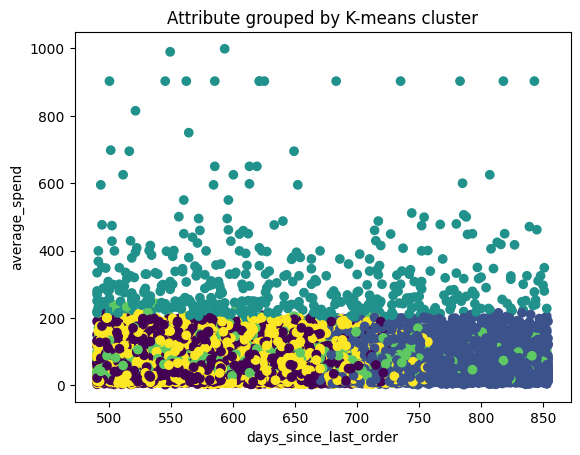

In [8]:
# prompt: 1. Using predictions_df, and matplotlib, generate a scatterplot. 2. On the x-axis of the scatterplot, display days_since_last_order and on the y-axis, display average_spend from predictions_df. 3. Color by cluster. The chart should be titled "Attribute grouped by K-means cluster."

import matplotlib.pyplot as plt
plt.scatter(predictions_df['days_since_last_order'], predictions_df['average_spend'], c=predictions_df['CENTROID_ID'])
plt.xlabel('days_since_last_order')
plt.ylabel('average_spend')
plt.title('Attribute grouped by K-means cluster')
plt.show()

In [9]:
query = """
SELECT
 CONCAT('cluster ', CAST(centroid_id as STRING)) as centroid,
 average_spend,
 count_orders,
 days_since_last_order
FROM (
 SELECT centroid_id, feature, ROUND(numerical_value, 2) as value
 FROM ML.CENTROIDS(MODEL `{0}.{1}`)
)
PIVOT (
 SUM(value)
 FOR feature IN ('average_spend',  'count_orders', 'days_since_last_order')
)
ORDER BY centroid_id
""".format(dataset_name, model_name)

df_centroid = client.query(query).to_dataframe()
df_centroid.head()

,centroid,average_spend,count_orders,days_since_last_order
0,cluster 1,54.12,1.37,583.22
1,cluster 2,54.60,1.30,774.39
2,cluster 3,347.04,1.25,644.63
3,cluster 4,58.98,3.79,622.12
4,cluster 5,53.88,1.30,597.56


In [10]:
df_query = client.query(query).to_dataframe()
df_query.to_string(header=False, index=False)

cluster_info = []
for i, row in df_query.iterrows():
 cluster_info.append("{0}, average spend ${2}, count of orders per person {1}, days since last order {3}"
  .format(row["centroid"], row["count_orders"], row["average_spend"], row["days_since_last_order"]) )

cluster_info = (str.join("\n", cluster_info))
print(cluster_info)

cluster 1, average spend $54.12, count of orders per person 1.37, days since last order 583.22
cluster 2, average spend $54.6, count of orders per person 1.3, days since last order 774.39
cluster 3, average spend $347.04, count of orders per person 1.25, days since last order 644.63
cluster 4, average spend $58.98, count of orders per person 3.79, days since last order 622.12
cluster 5, average spend $53.88, count of orders per person 1.3, days since last order 597.56


In [11]:
prompt = f"""
You're a creative brand strategist, given the following clusters, come up with \
creative brand persona, a catchy title, and next marketing action, \
explained step by step.

Clusters:
{cluster_info}

For each Cluster:
* Title:
* Persona:
* Next marketing step:
"""

In [12]:
# prompt: Use the Vertex AI language_models API to call the PaLM2 text-bison model and generate a marketing campaign using the variable prompt. Use the following model settings: max_output_tokens=1024, temperature=0.4

from vertexai.language_models import TextGenerationModel

model = TextGenerationModel.from_pretrained("text-bison")
response = model.predict(prompt=prompt, max_output_tokens=1024, temperature=0.4)
print(response.text)

 **Cluster 1:**

**Title:** The Occasional Treaters

**Persona:** These customers are budget-conscious and make infrequent purchases. They may be new to the brand or still exploring different options.

**Next marketing step:** Offer a special promotion or discount to encourage them to make a repeat purchase.

**Cluster 2:**

**Title:** The Loyal Few

**Persona:** These customers are also budget-conscious but have been with the brand for a longer period. They may be less likely to experiment with new products.

**Next marketing step:** Send them personalized emails or notifications about new products or promotions that align with their interests.

**Cluster 3:**

**Title:** The Big Spenders

**Persona:** These customers are high-value customers who spend a significant amount on each purchase. They may be brand enthusiasts or loyal customers who appreciate quality.

**Next marketing step:** Offer them exclusive perks or rewards to show appreciation for their loyalty.

**Cluster 4:**

**T

In [ ]:
# Delete customer_stats table

client.delete_table(f"{project_id}.{dataset_name}.{table_name}", not_found_ok=True)
print(f"Deleted table: {project_id}.{dataset_name}.{table_name}")


# Delete K-means model
client.delete_model(f"{project_id}.{dataset_name}.{model_name}", not_found_ok=True)
print(f"Deleted model: {project_id}.{dataset_name}.{model_name}")
